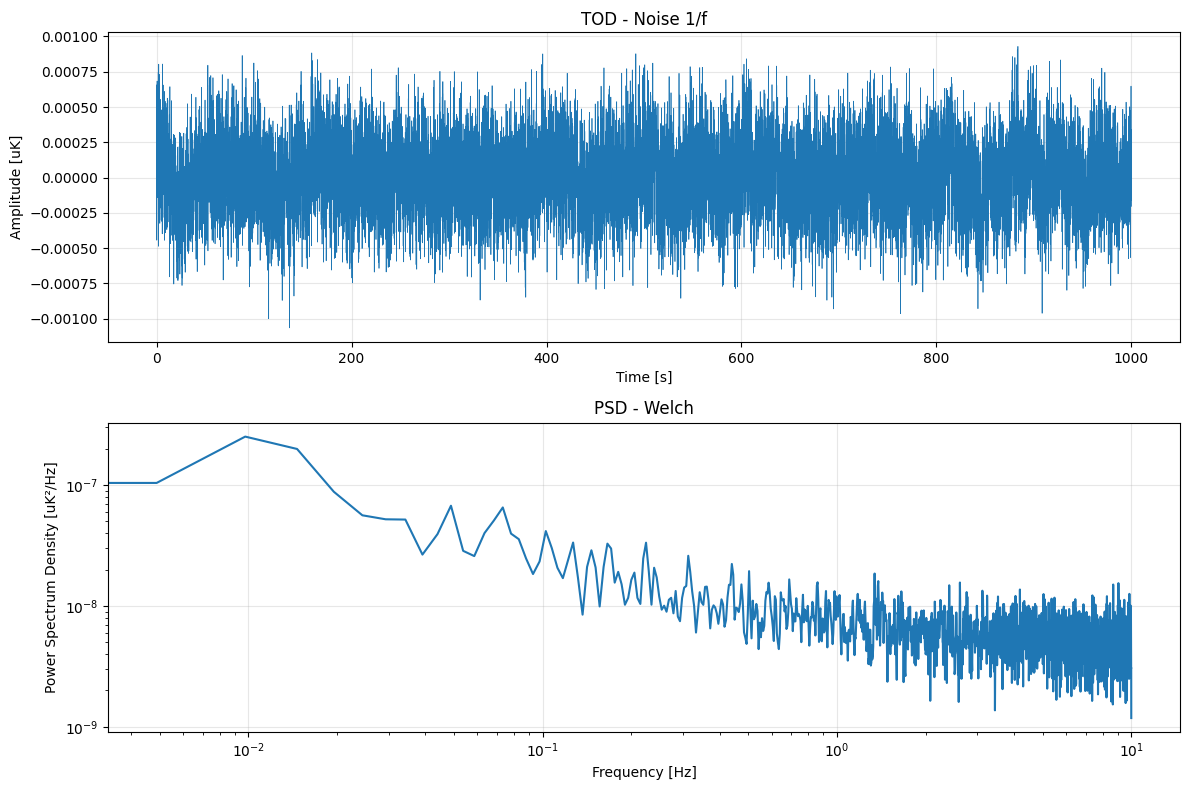

CPU times: user 932 ms, sys: 33.2 ms, total: 965 ms
Wall time: 1.09 s


In [5]:
%%time

import sys, os
sys.path.append(os.path.abspath("../mylib_project"))

from mylib import add_lbsNoise

import litebird_sim as lbs
from astropy.time import Time
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
import ducc0

start_time = 0
time_span_s = 1000.0

sim = lbs.Simulation(
    start_time=start_time,
    duration_s=time_span_s,
    random_seed=12345,
    imo=lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION) 
)

sim.set_scanning_strategy(
    lbs.SpinningScanningStrategy(
        spin_sun_angle_rad=np.deg2rad(0),
        precession_rate_hz=0,
        spin_rate_hz=1 / 60,
        start_time=start_time,
    ),
    delta_time_s=5.0,
)

sim.set_instrument(
    lbs.InstrumentInfo(
        boresight_rotangle_rad=0.0,
        spin_boresight_angle_rad=np.deg2rad(90),
        spin_rotangle_rad=np.deg2rad(75),
    )
)

det = lbs.DetectorInfo(
    name="Boresight_detector",
    sampling_rate_hz=20.,
    bandcenter_ghz=100.0,
    net_ukrts=50.0,
    fknee_mhz=500.,
    fmin_hz=1e-5,
    alpha=1
)


sim.create_observations(detectors=det)

tod = sim.observations[0].tod 

# Noise from LBS
add_lbsNoise(tod, det, block_duration_s=100) 


# PSD with Welch
frequencies, psd = welch(
    tod,
    fs=det.sampling_rate_hz,           
    window='hann',            
    nperseg=2**12,            
    noverlap=2**12 // 2,       
    scaling='density',        
)




plt.figure(figsize=(12, 8))

# --- TOD ---
plt.subplot(2, 1, 1)
time_axis = np.arange(tod.shape[1]) / det.sampling_rate_hz
plt.plot(time_axis, tod[0], linewidth=0.5)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [uK]')
plt.title('TOD - Noise 1/f')
plt.grid(True, alpha=0.3)

# --- PSD with Welch ---
plt.subplot(2, 1, 2)
plt.loglog(frequencies, psd[0], linewidth=1.5)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectrum Density [uK²/Hz]')
plt.title('PSD - Welch')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("graph_mock_lbs.pdf")
plt.show()